In [34]:
from typing import Annotated, List, TypedDict
from langgraph.graph.message import add_messages
from langchain_community.document_transformers import LongContextReorder
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from mcp import ClientSession, StdioServerParameters
from langchain_mcp_adapters.client import MultiServerMCPClient
from openai import OpenAI

load_dotenv()

model_client = OpenAI()

from typing import Any, List
from typing_extensions import TypedDict, Annotated
from langgraph.graph.message import add_messages

class ChatbotState(TypedDict):
    question:        Annotated[str, "Question"]
    tools:           Annotated[List, "Tools"]
    case_number:     Annotated[str, "Case_Number"]    # ← 추가
    full_name:       Annotated[str, "Full_Name"]      # ← 추가
    neo4j_documents: Annotated[Any, "Neo4j_Documents"]
    vector_documents:Annotated[Any, "Vector_Documents"]
    final_answer:    Annotated[str, "Final_Answer"]
    messages:        Annotated[List, add_messages]

memory = MemorySaver()


# MCP Multi-Tool Client
client = MultiServerMCPClient(
    {
        "local_patient_retriever": {
            "command": "/home/hyewon/boaz/bin/python",
            "args": ["/mnt/c/Users/user/BOAZ_ADV/Hyewon/mcp/mcp_local_patient_server.py"],
            "transport": "stdio",
        },
        "VectorDB_retriever": {
            "command": "/home/hyewon/boaz/bin/python",
            "args": ["/mnt/c/Users/user/BOAZ_ADV/Hyewon/mcp/mcp_vectordb_server.py"],
            "transport": "stdio",
        },
    }
)

tools = await client.get_tools()

tools_dict = {tool.name: tool for tool in tools}

print(tools_dict)

{'local_patient_retriever': StructuredTool(name='local_patient_retriever', description='\n    환자 케이스 번호(case) 혹은 full_name 으로 로컬 JSON 데이터에서 검색\n    ', args_schema={'properties': {'case_number': {'default': '', 'title': 'Case Number', 'type': 'string'}, 'full_name': {'default': '', 'title': 'Full Name', 'type': 'string'}}, 'title': 'local_patient_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7901a014c160>), 'VectorDB_retriever': StructuredTool(name='VectorDB_retriever', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'VectorDB_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7901a0507f40>)}


In [35]:
tools = [
    {
        "type": "function",
        "name": "local_patient_retriever",
        "description": "Query local patient cases by full_name or case_number.",
        "parameters": {
            "type": "object",
            "properties": {
                "case_number": {
                    "type": "string",
                    "description": "Patient case number (e.g., APM-12-243)"
                },
                "full_name": {
                    "type": "string",
                    "description": "Patient full name (e.g., 최도윤)"
                }
            },
            "required": [],
            "additionalProperties": False
        }
    },
    {
        "type": "function",
        "name": "VectorDB_retriever",
        "description": "Retrieve general medical knowledge (diseases, treatments, guidelines).",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "Query about medical knowledge"
                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    }
]

In [36]:
LLM_SYSTEM_PROMPT = """
# INSTRUCTION
당신은 의료 데이터에 특화된 전문가 AI입니다.
사용자의 질문에 대해 다음 두 가지 출처의 정보를 참고하여 답변을 생성하세요:

1. 🏥 Local Patient Data:  
   - local_patient_retriever 툴을 통해 로컬 JSON에서 가져온 환자 케이스 정보  
2. 📚 VectorDB 검색 결과:  
   - general medical knowledge (질환 설명, 치료 가이드라인 등)

- 두 결과가 모두 존재하면, 각각 구분하여 요약 후 통합하세요.  
- 한 쪽만 존재하면 그 결과만으로 답변하세요.  
- 불필요한 서론 없이, 질문에 바로 답변해주세요.

# Local Patient CONTEXT
{LocalPatient}

# Vector DB CONTEXT
{VectorDB}

# Question
{question}
"""

model = ChatOpenAI(
    temperature=0.2,
    model_name="gpt-4o"
)

In [46]:
import re

# --- 1) extract_id node: parse case_number or full_name from question ---
async def extract_id(state: ChatbotState) -> ChatbotState:
    q = state["question"]
    # Attempt to extract case number pattern
    m = re.search(r"(APM-\d{2}-\d+)", q)
    if m:
        return {**state, "case_number": m.group(1)}
    # Otherwise, treat question text after "환자인 " or name presence as full_name
    # Here we assume full_name is the first Korean word before "환자"
    nm_match = re.search(r"([가-힣]{2,4})\s*환자", q)
    if nm_match:
        name = nm_match.group(1)
        return {**state, "full_name": name}
    return state

async def decision_tools(state: ChatbotState):
    
    question = state["question"]

    input_messages = [
        {"role": "system", "content": "Decide which tools to use to answer the user's question. You may call one or both."},
        {"role": "user", "content": question}
    ]
    
    response = model_client.responses.create(model="gpt-4.1",
                                             input=input_messages,
                                             tools=tools)

    selected_tools = [tool.name for tool in response.output]

    return ChatbotState(tools=selected_tools)

async def vector_db(state: ChatbotState):
    question = state["question"]
    
    if "VectorDB_retriever" in state["tools"]:
        vectordb_tool = tools_dict["VectorDB_retriever"]
        
        if vectordb_tool:
            result = await vectordb_tool.ainvoke({"query": question})
        else:
            result = "VectorDB 도구를 찾을 수 없습니다."
    else:
        result = None

    return ChatbotState(vector_documents=result)

# --- 4) local_patient_db node: call local_patient_retriever with both params ---
async def local_patient_db(state: ChatbotState) -> ChatbotState:
    if "local_patient_retriever" in state["tools"]:
        tool = tools_dict["local_patient_retriever"]
        params = {
            "case_number": state.get("case_number", ""),
            "full_name"  : state.get("full_name", "")
        }
        result = await tool.ainvoke(params)
    else:
        result = None
    return {**state, "neo4j_documents": result}
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

import json
from langchain.schema import AIMessage  # ← 여기를 이렇게 바꿔주세요

async def merge_outputs(state: ChatbotState) -> ChatbotState:
    # 1) 로컬 환자 데이터와 VectorDB 데이터를 꺼내고
    local_patient_data = state.get("neo4j_documents", {})
    vector_data        = state.get("vector_documents", {})

    # 2) 시스템 프롬프트 생성
    system_content = LLM_SYSTEM_PROMPT.format(
        LocalPatient=json.dumps(local_patient_data, ensure_ascii=False),
        VectorDB=json.dumps(vector_data, ensure_ascii=False),
        question=state["question"]
    )

    # 3) 메시지 리스트 구성
    messages = [
        {"role": "system", "content": system_content},
        {"role": "user",   "content": state["question"]}
    ]

    # 4) 리스트 그대로 ainvoke 에 넘겨서 호출
    resp: AIMessage = await model.ainvoke(messages)

    # 5) 응답에서 본문만 꺼내기
    text = resp.content

    # 6) 최종 상태 업데이트
    return {
        **state,
        "final_answer": text,
        "messages": [("user", state["question"]), ("assistant", text)]
    }


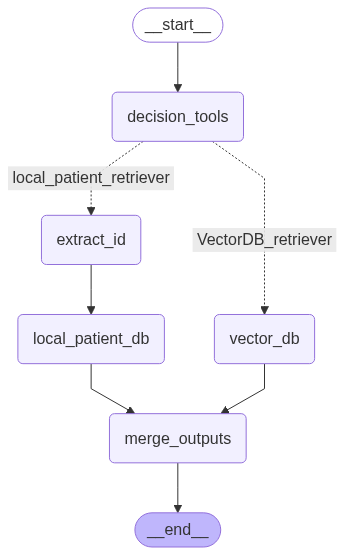

In [48]:
# --- Build the graph ---

builder = StateGraph(ChatbotState)
builder.add_node("extract_id", extract_id)
builder.add_node("decision_tools", decision_tools)
builder.add_node("vector_db", vector_db)
builder.add_node("local_patient_db", local_patient_db)
builder.add_node("merge_outputs", merge_outputs)

# 1) START → decision_tools
builder.add_edge(START, "decision_tools")

# 2) decision_tools → (local_patient or vector) 분기
builder.add_conditional_edges(
    "decision_tools",
    route_tools,
    {
        "local_patient_retriever": "extract_id",   # 환자 경로: 먼저 extract_id
        "VectorDB_retriever":      "vector_db"   # 의료지식 경로는 바로 vector_db
    }
)

# 3) 환자 경로: extract_id → local_patient_db → merge_outputs
builder.add_edge("extract_id",       "local_patient_db")
builder.add_edge("local_patient_db", "merge_outputs")

# 4) vector 경로: vector_db → merge_outputs
builder.add_edge("vector_db",        "merge_outputs")

# 5) merge_outputs → END
builder.add_edge("merge_outputs",    END)

builder.compile(checkpointer=memory)


In [53]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id": 1})

question = "11세 남아인 최도윤 환자가 가진 질병과 받을 수술을 알려줘"

graph = builder.compile(checkpointer=memory)

# initial_state = {
#     "question": question,
#     "tools": [],
#     "neo4j_documents": [],
#     "vector_documents": [],
#     "final_answer": "",
#     "messages": [],
# }

initial_state = {
    "question": question,
    "tools": [],
    "case_number": "",
    "full_name": "",
    "neo4j_documents": None,
    "vector_documents": None,
    "final_answer": "",
    "messages": []
}


# events = []
# async for event in graph.astream(initial_state, config=config):
#     print(event)


events = []
async for event in graph.astream(initial_state, config=config):
    # merge_outputs 단계에서만 처리
    if "merge_outputs" in event:
        out = event["merge_outputs"]
        print("=== 최종 결과 ===")
        print("질문         :", out["question"])
        print("\n-- Local Patient Context --")
        print(out["neo4j_documents"])        # local_patient_db에서 넘어온 JSON
        print("\n-- Vector DB Context --")
        print(out["vector_documents"])       # vector_db에서 넘어온 결과
        print("\n-- 답변 --")
        print(out["final_answer"])




=== 최종 결과 ===
질문         : 11세 남아인 최도윤 환자가 가진 질병과 받을 수술을 알려줘

-- Local Patient Context --
{
  "case": "APM-12-243",
  "full_name": "최도윤",
  "age": "11세 남아",
  "diagnosis": "거대방광요관역류",
  "surgery": "요관 재건술",
  "anesthesia": "전신마취",
  "agent": [
    "Sevoflurane"
  ],
  "notes": "과거 마취력 있음, 항생제 전처치 포함"
}

-- Vector DB Context --
None

-- 답변 --
최도윤 환자는 "거대방광요관역류"라는 질병을 가지고 있으며, "요관 재건술"을 받을 예정입니다.


In [ ]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id": 1})

question = "Kasabach-Merrritt Syndrome이 뭐야?"

graph = builder.compile(checkpointer=memory)

# initial_state = {
#     "question": question,
#     "tools": [],
#     "neo4j_documents": [],
#     "vector_documents": [],
#     "final_answer": "",
#     "messages": [],
# }

initial_state = {
    "question": question,
    "tools": [],
    "case_number": "",
    "full_name": "",
    "neo4j_documents": None,
    "vector_documents": None,
    "final_answer": "",
    "messages": []
}


# events = []
# async for event in graph.astream(initial_state, config=config):
#     print(event)


events = []
async for event in graph.astream(initial_state, config=config):
    # merge_outputs 단계에서만 처리
    if "merge_outputs" in event:
        out = event["merge_outputs"]
        print("=== 최종 결과 ===")
        print("질문         :", out["question"])
        print("\n-- Local Patient Context --")
        print(out["neo4j_documents"])        # local_patient_db에서 넘어온 JSON
        print("\n-- Vector DB Context --")
        print(out["vector_documents"])       # vector_db에서 넘어온 결과
        print("\n-- 답변 --")
        print(out["final_answer"])



질문: Kasabach-Merrritt Syndrome이 뭐야?
답변: Kasabach-Merritt Syndrome (KMS)는 혈관종과 관련된 드문 혈액 응고 장애입니다. 이 증후군은 거대 혈관종(hemangioendothelioma)과 혈전증(thrombosis)이 발생하여 혈소판 감소증(thrombocytopenia)을 초래하는 것이 특징입니다. KMS는 또한 파종성 혈관 내 응고(disseminated intravascular coagulation, DIC)와 관련될 수 있습니다. 이 증후군은 주로 유아에서 발생하며, 혈관종이 혈소판을 소모하여 출혈 경향을 증가시킵니다. 치료는 주로 혈관종의 크기를 줄이고 혈소판 수치를 정상화하는 데 중점을 둡니다.


In [54]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id": 1})

question = "최도윤 환자의 수술명과 기관삽관 시 주의할 점을 알려줘."

graph = builder.compile(checkpointer=memory)

# initial_state = {
#     "question": question,
#     "tools": [],
#     "neo4j_documents": [],
#     "vector_documents": [],
#     "final_answer": "",
#     "messages": [],
# }

initial_state = {
    "question": question,
    "tools": [],
    "case_number": "",
    "full_name": "",
    "neo4j_documents": None,
    "vector_documents": None,
    "final_answer": "",
    "messages": []
}


# events = []
# async for event in graph.astream(initial_state, config=config):
#     print(event)


events = []
async for event in graph.astream(initial_state, config=config):
    # merge_outputs 단계에서만 처리
    if "merge_outputs" in event:
        out = event["merge_outputs"]
        print("=== 최종 결과 ===")
        print("질문         :", out["question"])
        print("\n-- Local Patient Context --")
        print(out["neo4j_documents"])        # local_patient_db에서 넘어온 JSON
        print("\n-- Vector DB Context --")
        print(out["vector_documents"])       # vector_db에서 넘어온 결과
        print("\n-- 답변 --")
        print(out["final_answer"])


InvalidUpdateError: At key 'vector_documents': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE